In [1]:
import os
import sys

sys.path.insert(0, os.path.join(os.path.abspath(""), "..", ".."))

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from infovar.stats import entropy_estimators as ee

base = 2

In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

data = housing.data.copy()
target = housing.target.copy()

In [3]:
n_iter_errors = 20

### No scaling

In [4]:
mis = {}

for i, feature in enumerate(tqdm(housing.feature_names)):

    _mi = [None] * n_iter_errors
    for it in range(n_iter_errors):

        x = data[:, i] + np.random.normal(0, np.std(data[:, i]) * 1e-3, size=data[:, i].shape)
        y = target + np.random.normal(0, np.std(target) * 1e-3, size=target.shape)

        _mi[it] = ee.mi(y.reshape(-1, 1), x.reshape(-1, 1))
    
    mis.update({
        feature: _mi 
    })

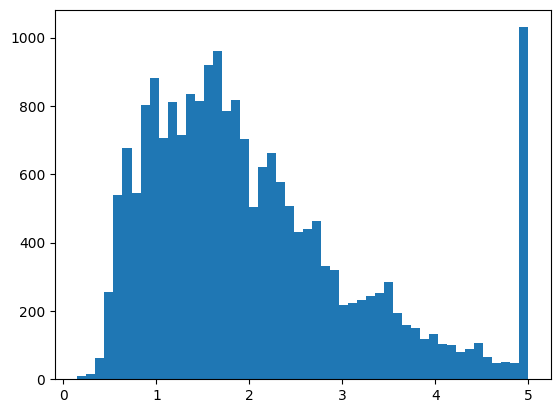

In [5]:
plt.figure()

plt.hist(target, bins=50, label=f'{housing.target_names[0]}')

plt.show()

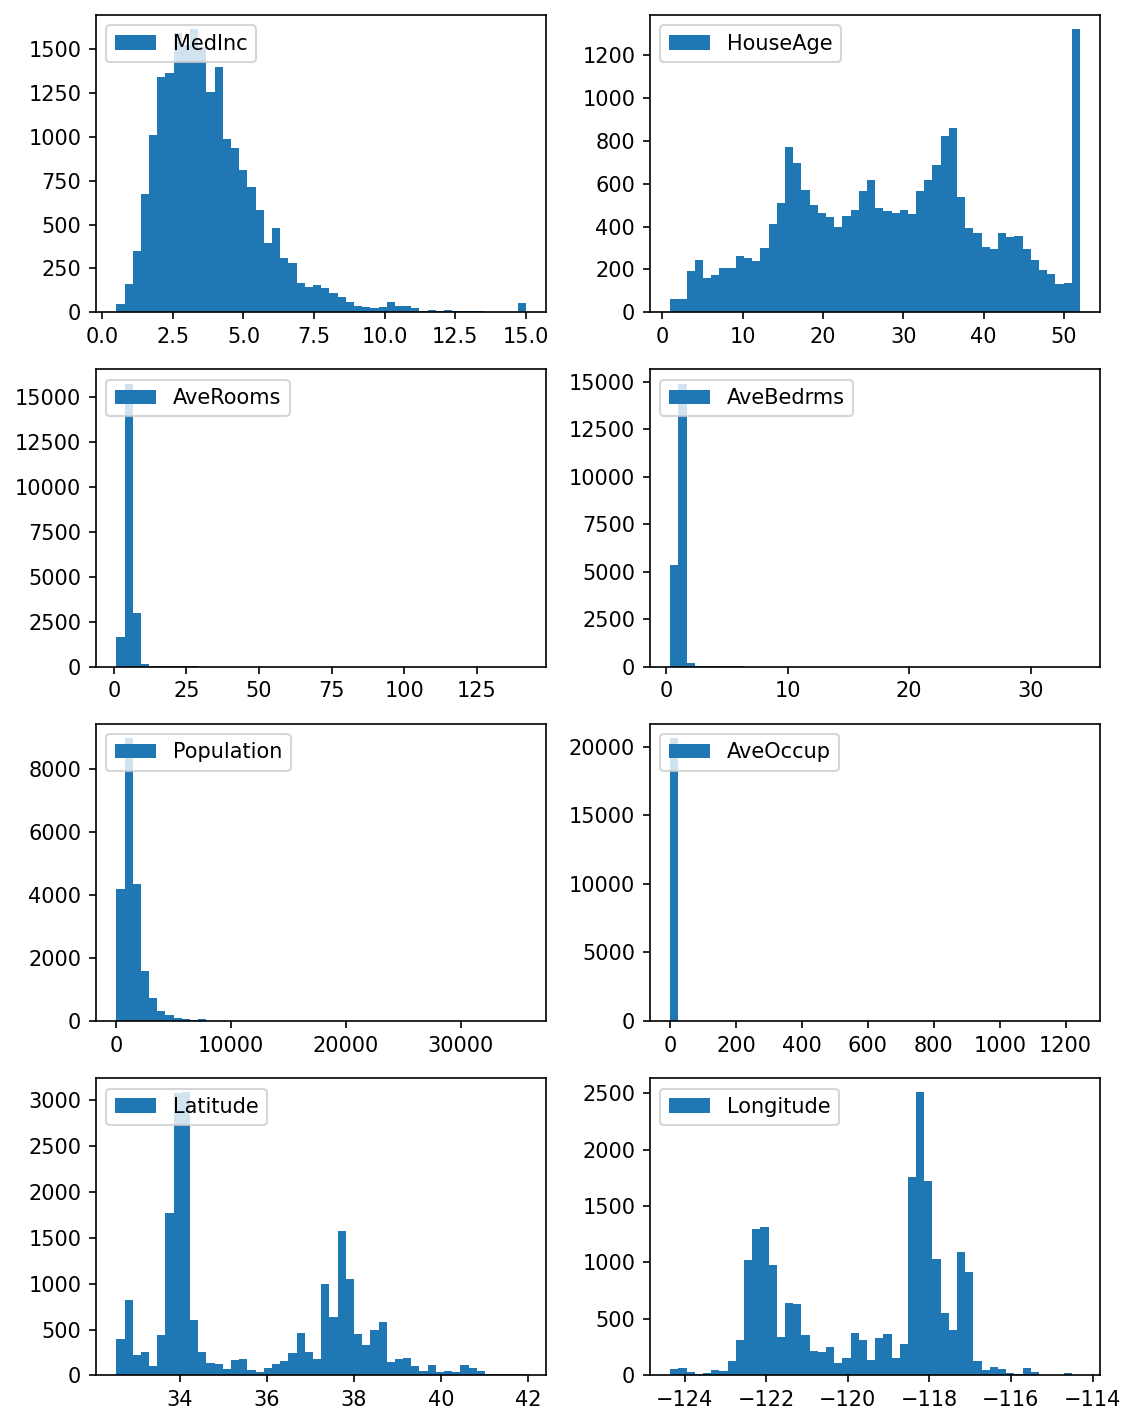

In [6]:
plt.figure(figsize=(1.2*6.4, 2*4.8), dpi=150)

for i, feature in enumerate(housing.feature_names):

    plt.subplot(4, 2, i+1)

    plt.hist(data[:, i], bins=50, label=f'{feature}')

    plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

### Log scaling

In [7]:
data_sc = data.copy()
target_sc = target.copy()

i = housing.feature_names.index("AveRooms")
data_sc[:, i] = np.log10( data_sc[:, i] )

i = housing.feature_names.index("AveBedrms")
data_sc[:, i] = np.log10( data_sc[:, i] )

i = housing.feature_names.index("Population")
data_sc[:, i] = np.log10( data_sc[:, i] )

i = housing.feature_names.index("AveOccup")
data_sc[:, i] = np.log10( data_sc[:, i] )

In [8]:
mis_sc = {}

for i, feature in enumerate(tqdm(housing.feature_names)):

    _mi = [None] * n_iter_errors
    for it in range(n_iter_errors):

        x = data_sc[:, i] + np.random.normal(0, np.std(data_sc[:, i]) * 1e-3, size=data_sc[:, i].shape)
        y = target_sc + np.random.normal(0, np.std(target_sc) * 1e-3, size=target_sc.shape)

        _mi[it] = ee.mi(y.reshape(-1, 1), x.reshape(-1, 1))
    
    mis_sc.update({
        feature: _mi 
    })

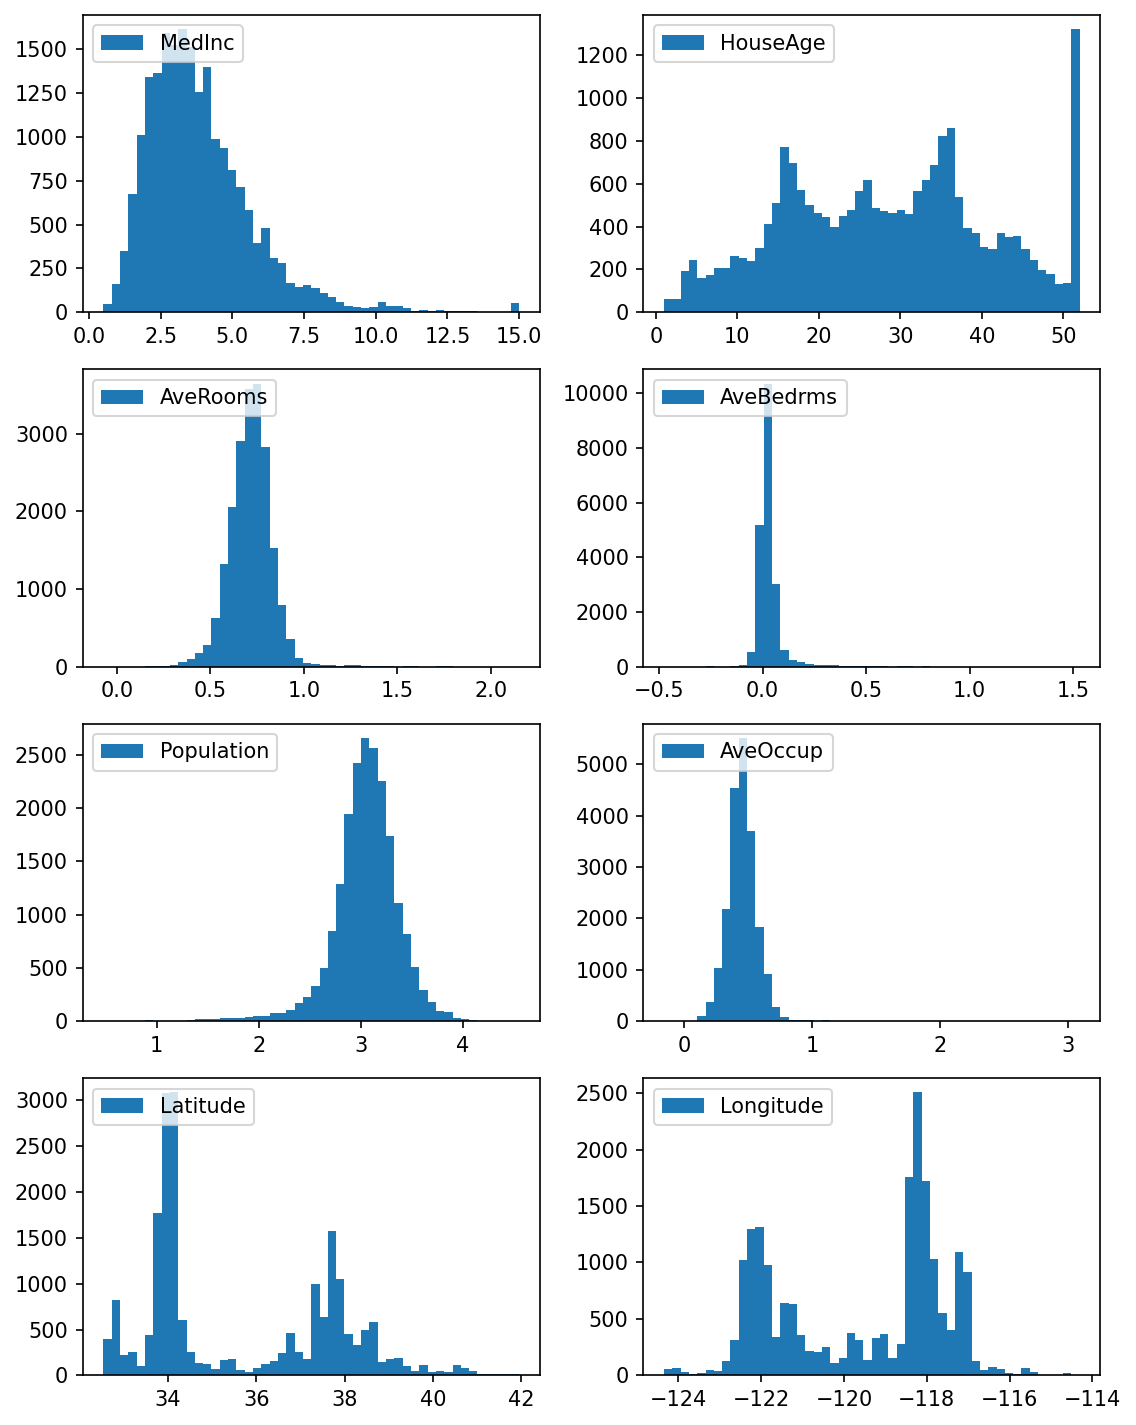

In [9]:
plt.figure(figsize=(1.2*6.4, 2*4.8), dpi=150)

for i, feature in enumerate(housing.feature_names):

    plt.subplot(4, 2, i+1)

    plt.hist(data_sc[:, i], bins=50, label=f'{feature}')

    plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

### Mean-variance scaling

In [10]:
data_norm = data_sc.copy()
target_norm = target_sc.copy()

for feature in housing.feature_names:

    i = housing.feature_names.index(feature)
    data_norm[:, i] = (data_norm[:, i] - np.mean(data_norm[:, i])) / np.std(data_norm[:, i])

target_norm = (target_norm - np.mean(target_norm)) / np.std(target_norm)

In [11]:
mis_norm = {}

for i, feature in enumerate(tqdm(housing.feature_names)):

    _mi = [None] * n_iter_errors
    for it in range(n_iter_errors):

        x = data_norm[:, i] + np.random.normal(0, np.std(data_norm[:, i]) * 1e-3, size=data_norm[:, i].shape)
        y = target_norm + np.random.normal(0, np.std(target_norm) * 1e-3, size=target_norm.shape)

        _mi[it] = ee.mi(y.reshape(-1, 1), x.reshape(-1, 1))
    
    mis_norm.update({
        feature: _mi 
    })

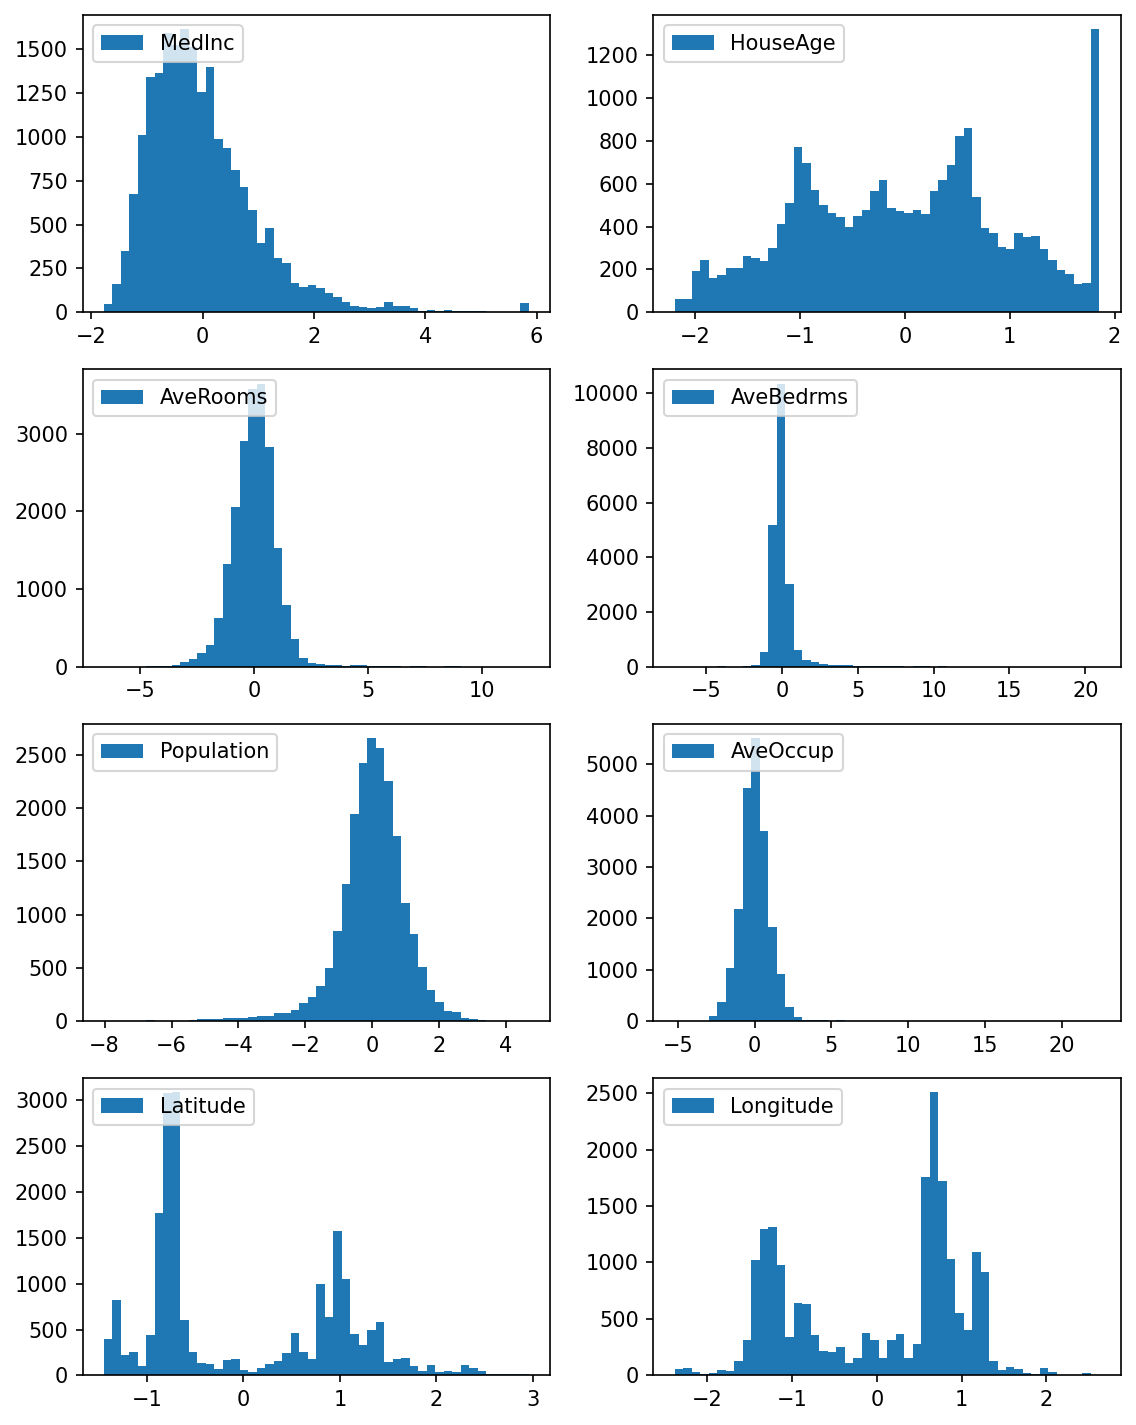

In [12]:
plt.figure(figsize=(1.2*6.4, 2*4.8), dpi=150)

for i, feature in enumerate(housing.feature_names):

    plt.subplot(4, 2, i+1)

    plt.hist(data_norm[:, i], bins=50, label=f'{feature}')

    plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

### Comparison of MIs

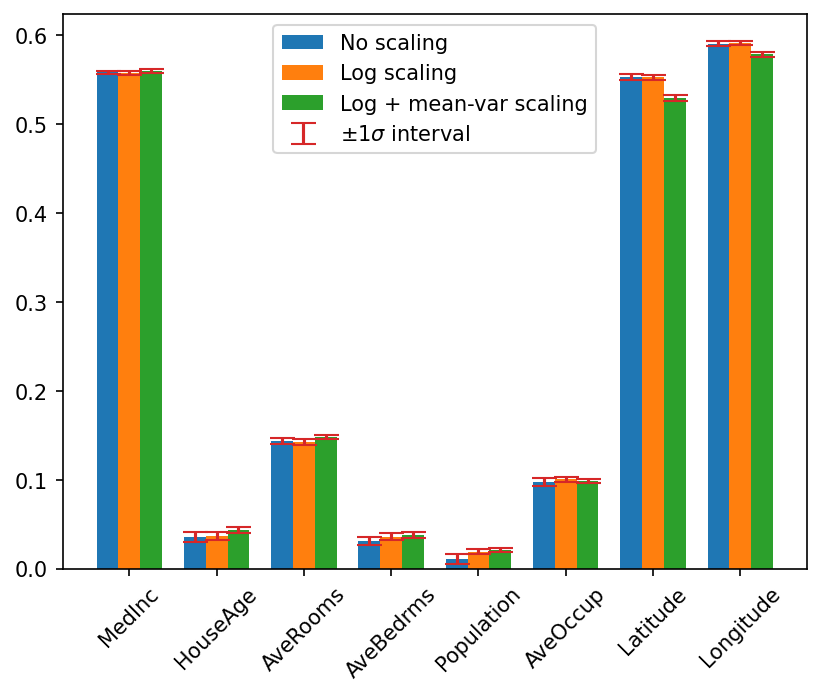

In [13]:
xticks = np.arange(len(housing.feature_names))
w = 0.25

plt.figure(dpi=150)

plt.bar(xticks-w, [np.mean(mis[f]) for f in housing.feature_names], width=w, label="No scaling")
plt.bar(xticks, [np.mean(mis_sc[f]) for f in housing.feature_names], width=w, label="Log scaling")
plt.bar(xticks+w, [np.mean(mis_norm[f]) for f in housing.feature_names], width=w, label="Log + mean-var scaling")

plt.errorbar(xticks-w, [np.mean(mis[f]) for f in housing.feature_names], [np.std(mis[f]) for f in housing.feature_names], color="tab:red", capsize=6, fmt="none", label="$\pm 1\\sigma$ interval")
plt.errorbar(xticks, [np.mean(mis_sc[f]) for f in housing.feature_names], [np.std(mis_sc[f]) for f in housing.feature_names],color="tab:red", capsize=6, fmt="none")
plt.errorbar(xticks+w, [np.mean(mis_norm[f]) for f in housing.feature_names], [np.std(mis_norm[f]) for f in housing.feature_names],color="tab:red", capsize=6, fmt="none")

plt.xticks(xticks, labels=housing.feature_names, rotation=45)

plt.legend()

plt.show()

### Conclusions

Le scaling des variables a un impact sur le calcul de l'information mutuel, bien que théoriquement elle ne devrait pas.
Elle possède également la propriété intéressante de permettre d'ajouter un bruit de dynamique constante pour toutes les variables (voir `degeneracy.ipynb`).

La procédure conseillée est donc la suivante :
1. Appliquer un log (ou transformation similaire comme arcsinh) aux données pour leur donner une allure gaussienne.
2. Appliquer une normalisation, par exemple moyenne-variance afin d'éviter un effet de taille
3. Effectuer le calcul de l'information mutuelle